In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [2]:
def standardize_cols(X):
    zscore = lambda x: (x.mean() - x)/x.std()
    return pd.DataFrame(X).apply(zscore).values
    
def log_transform_cols(X):
     return np.log(X + 0.1)

def binarize_cols(X):
    temp = X.copy()
    temp[temp > 0] = 1
    temp[temp <= 0] = 0
    return temp

In [3]:
spam_data = scipy.io.loadmat("data/spam.mat")
Xraw = pd.DataFrame(spam_data['Xtrain'])
y = spam_data['Ytrain'].reshape((3450,))
Xtestraw = pd.DataFrame(spam_data['Xtest'])
print(Xraw.shape, y.shape, Xtestraw.shape)

stan_X = pd.DataFrame(standardize_cols(Xraw.values))
log_X = pd.DataFrame(np.log(Xraw.values + 0.1))
bin_X = pd.DataFrame(binarize_cols(Xraw.values))
stan_X[57] = 1
log_X[57] = 1
bin_X[57] = 1
Xraw[57] = 1
X = Xraw.values
stan_X = stan_X.values
log_X = log_X.values
bin_X = bin_X.values
print(X.shape, stan_X.shape, log_X.shape, bin_X.shape)

(3450, 57) (3450,) (1151, 57)
(3450, 58) (3450, 58) (3450, 58) (3450, 58)


In [155]:
from random import shuffle

def quadratic_kernel(xi, X):
    return (np.dot(X, xi) + 1) ** 2

def quadratic_kernel_f(xi, X, alphai):
#    pre = alpha * quadratic_kernel(xi, X)
# there seems to be something possibly weird in here
# pre is the un summed version
#    print(np.dot(alpha, quadratic_kernel(xi, X)))

#     print(quadratic_kernel(xi, X))
#     print(alphai)
#     print(np.dot(alphai, quadratic_kernel(xi, X)))
    
    return np.sum(np.dot(alphai, quadratic_kernel(xi, X)))

#    return np.dot(alphai, quadratic_kernel(xi, X))
    
def quadratic_kernel_ridge_sgd(xi, yi, X, alphai, gamma, lr):
    fx = quadratic_kernel_f(xi, X, alphai)
    z = np.dot(yi,fx)
    sz = lambda z: 1 / (1 + np.exp(-z))
    new_alpha = alphai - ((gamma * alphai) + (lr * sz(z) * yi))
    risk = np.log(1 + np.exp(sz(z)))
    return new_alpha, risk

def qkrsgd_wrapper(X, y, gamma, lr, num_iters):
    shuff = list(range(len(X)))
    shuffle(shuff)
    alpha = np.random.randn(len(X))
#    alpha = np.zeros(len(X))
    X = X[shuff]
    y = y[shuff]
    risks = []
    for count in range(num_iters):
        temp_risk = []
        for count, (xi, yi, alphai) in enumerate(zip(X, y, alpha)):
            new_alpha, risk = quadratic_kernel_ridge_sgd(xi, yi, X, alphai, gamma, lr)
            temp_risk.append(risk)
#             print(new_alpha)
            alpha[count] = new_alpha
        risks.append(np.sum(temp_risk))
    return alpha, pd.DataFrame({"risk":risks})

In [156]:
tx, ty = stan_X[:12], y[:12]

In [157]:
w2, risks2 = qkrsgd_wrapper(stan_X, y, 10e-5, 0.005, 1000)
print(w2)

[-0.00442191 -0.0011706   0.00328459 ..., -0.00023119 -0.00331237
  0.00411019]


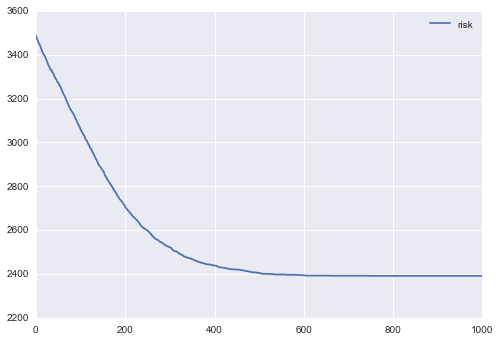

In [158]:
risks2.plot()